In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SQLContext, SparkSession, Window
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col, split, explode, array, regexp_replace, length, expr
import pyspark.sql.functions as F

In [2]:
spark = SparkSession.Builder().appName('DDAM_Project_Mushrooms').getOrCreate()
sql_ctx = SQLContext(spark)

mushroom_df = spark.read.options(inferSchema = True, delimiter = ';', header = True).csv('dataset/secondary_data.csv')

24/05/30 20:07:55 WARN Utils: Your hostname, Francescos-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.5 instead (on interface en0)
24/05/30 20:07:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/30 20:07:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/Users/effepielle/Developer/university/unipi/ddam/ddam-2324/.venv/lib/python3.11/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Data Understanding

In [3]:
mushroom_df.count()

61069

In [4]:
mushroom_df.show()

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|    p|       15.26|        x|          g|        o|                   f|              e|        NULL|         w|      16.95|     17.09|        s|           y|         w|        u|         w|       t|        g|             NULL|      d|     w|
|    p|        16.6|    

In [5]:
mushroom_df.dtypes

[('class', 'string'),
 ('cap-diameter', 'double'),
 ('cap-shape', 'string'),
 ('cap-surface', 'string'),
 ('cap-color', 'string'),
 ('does-bruise-or-bleed', 'string'),
 ('gill-attachment', 'string'),
 ('gill-spacing', 'string'),
 ('gill-color', 'string'),
 ('stem-height', 'double'),
 ('stem-width', 'double'),
 ('stem-root', 'string'),
 ('stem-surface', 'string'),
 ('stem-color', 'string'),
 ('veil-type', 'string'),
 ('veil-color', 'string'),
 ('has-ring', 'string'),
 ('ring-type', 'string'),
 ('spore-print-color', 'string'),
 ('habitat', 'string'),
 ('season', 'string')]

Missing Values Visualization

In [6]:
missing = mushroom_df.select([count(when(isnull(c), c)).alias(c) for c in mushroom_df.columns])
missing.show()

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|    0|           0|        0|      14120|        0|                   0|           9884|       25063|         0|          0|         0|    51538|       38124|         0|    57892|     53656|       0|     2471|            54715|      0|     0|
+-----+------------+----

## Categorical attributes analysis

In [7]:
cat_cols = [element[0] for element in mushroom_df.dtypes if element[1] == 'string']
print('The numerical columns are')
print(cat_cols)

The numerical columns are
['class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']


In [8]:
for c in cat_cols:
    print(f'column {c} contains {len(mushroom_df.select(c).distinct().collect())} distinct values')

column class contains 2 distinct values
column cap-shape contains 7 distinct values
column cap-surface contains 12 distinct values
column cap-color contains 12 distinct values
column does-bruise-or-bleed contains 2 distinct values
column gill-attachment contains 8 distinct values
column gill-spacing contains 4 distinct values
column gill-color contains 12 distinct values
column stem-root contains 6 distinct values
column stem-surface contains 9 distinct values
column stem-color contains 13 distinct values
column veil-type contains 2 distinct values
column veil-color contains 7 distinct values
column has-ring contains 2 distinct values
column ring-type contains 9 distinct values
column spore-print-color contains 8 distinct values
column habitat contains 8 distinct values
column season contains 4 distinct values


In [9]:
for c in cat_cols:
  print(f'column {c} distinct values are: ')
  results = mushroom_df.select(c).distinct().collect()

  results_string = ''
  for row in results:
    results_string += f"{str(row[c])} "
  print(results_string)
  print()

column class distinct values are: 
e p 

column cap-shape distinct values are: 
x f o p c b s 

column cap-surface distinct values are: 
l g k e h d y w i t s None 

column cap-color distinct values are: 
l g n k e o p w y u b r 

column does-bruise-or-bleed distinct values are: 
f t 

column gill-attachment distinct values are: 
x f e p d a s None 

column gill-spacing distinct values are: 
f d c None 

column gill-color distinct values are: 
g f n k e o p w y u b r 

column stem-root distinct values are: 
f c b r s None 

column stem-surface distinct values are: 
g f k h y i t s None 

column stem-color distinct values are: 
l g f n k e o p w y u b r 

column veil-type distinct values are: 
u None 

column veil-color distinct values are: 
n k e w y u None 

column has-ring distinct values are: 
f t 

column ring-type distinct values are: 
l g m f e z p r None 

column spore-print-color distinct values are: 
g n k p w u r None 

column habitat distinct values are: 
l g m h p d w u 

c

In [10]:
for c in cat_cols:
  print(f'column {c} distinct values counts are: ')
  mushroom_df.groupBy(c).count().orderBy('count', ascending=False).show()

column class distinct values counts are: 
+-----+-----+
|class|count|
+-----+-----+
|    p|33888|
|    e|27181|
+-----+-----+

column cap-shape distinct values counts are: 
+---------+-----+
|cap-shape|count|
+---------+-----+
|        x|26934|
|        f|13404|
|        s| 7164|
|        b| 5694|
|        o| 3460|
|        p| 2598|
|        c| 1815|
+---------+-----+

column cap-surface distinct values counts are: 
+-----------+-----+
|cap-surface|count|
+-----------+-----+
|       NULL|14120|
|          t| 8196|
|          s| 7608|
|          y| 6341|
|          h| 4974|
|          g| 4724|
|          d| 4432|
|          e| 2584|
|          k| 2303|
|          i| 2225|
|          w| 2150|
|          l| 1412|
+-----------+-----+

column cap-color distinct values counts are: 
+---------+-----+
|cap-color|count|
+---------+-----+
|        n|24218|
|        y| 8543|
|        w| 7666|
|        g| 4420|
|        e| 4035|
|        o| 3656|
|        r| 1782|
|        u| 1709|
|        p| 170

Categorical variables bar plot

In [11]:
mushroom_df.createOrReplaceTempView("Mushrooms_Data")

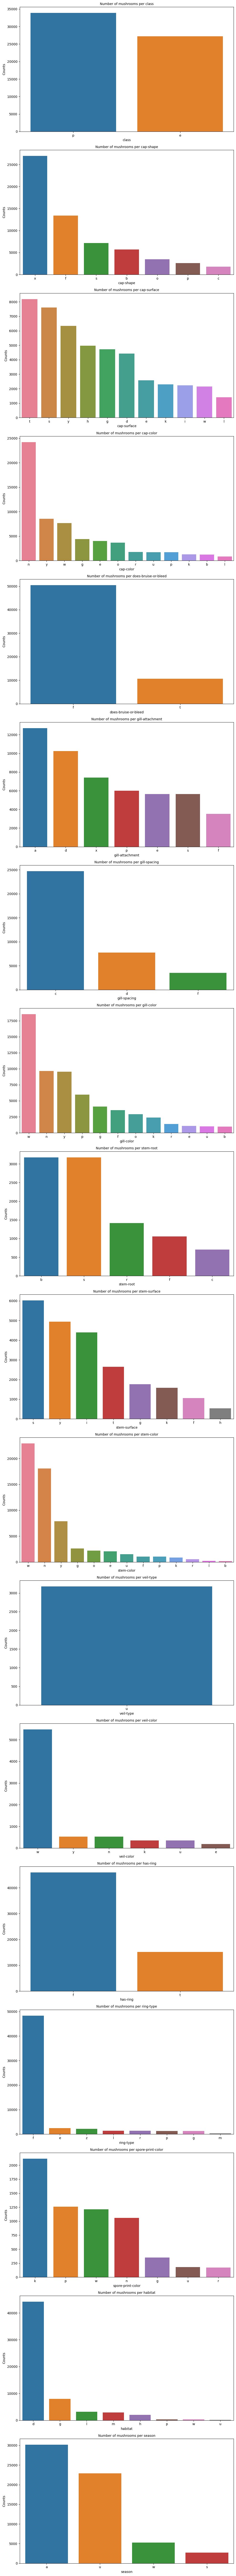

In [12]:
fig, axs = plt.subplots(len(cat_cols), figsize=(10, 6*len(cat_cols)))

for i, c in enumerate(cat_cols):
    col_counts = spark.sql(f"SELECT `{c}`, COUNT(*) as count FROM Mushrooms_Data WHERE `{c}` IS NOT NULL GROUP BY `{c}`").toPandas()
    col_counts = col_counts.sort_values(by='count', ascending=False)
    sns.barplot(x=c, y="count", hue=c, data=col_counts, ax=axs[i])
    axs[i].set_xlabel(c, size=10)
    axs[i].set_ylabel("Counts", size=10)
    axs[i].set_title(f"Number of mushrooms per {c}", size=10)
    #unique_col_values = col_counts[col].unique()
    #axs[i].legend(title=col, labels=unique_col_values)

plt.tight_layout()
plt.show()

## Continuous attribute analysis

In [13]:
num_cols = [element[0] for element in mushroom_df.dtypes if element[1] != 'string']
print('The numerical columns are')
print(num_cols)

The numerical columns are
['cap-diameter', 'stem-height', 'stem-width']


In [14]:
mushroom_df.select(num_cols).describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
cap-diameter,61069,6.733854492459317,5.264844947062989,0.38,62.34
stem-height,61069,6.581538260001019,3.3700168612896366,0.0,33.92
stem-width,61069,12.149410011626177,10.03595504311756,0.0,103.91


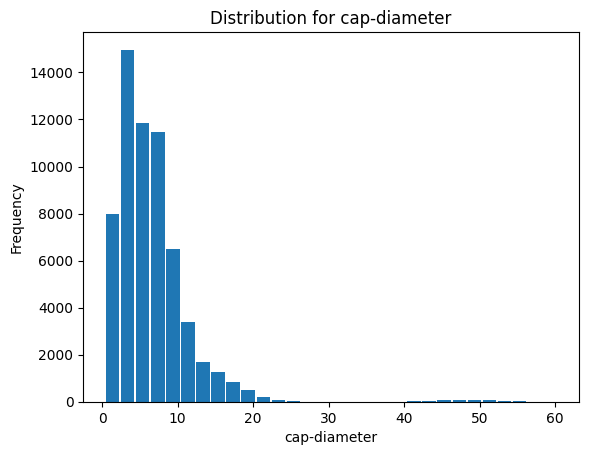

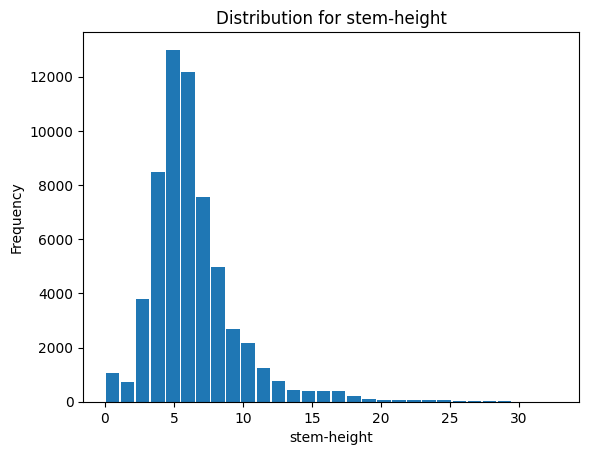

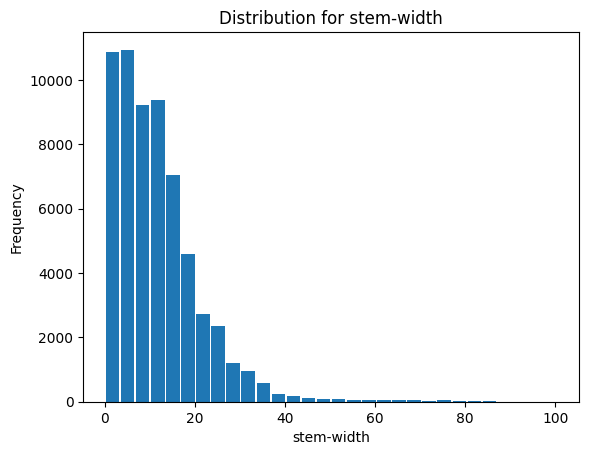

In [15]:
for c in num_cols:
    query = spark.sql(f'SELECT `{c}` FROM Mushrooms_Data')
    h = query.select(c).rdd.flatMap(lambda x: x).histogram(30)
    dfh = pd.DataFrame(
        list(zip(*h)),
        columns=['bin', 'frequency']
    )
    bins = dfh['bin']
    counts = dfh['frequency']
    plt.title(f"Distribution for {c}")
    plt.hist(bins, len(bins), weights=counts, rwidth=0.9)
    plt.xlabel(f'{c}', size=10)
    plt.ylabel("Frequency", size=10)
    plt.show()

## Cross-Analysis

/var/folders/n8/0xyp_8ms7sx0vdtw_lzp5dv00000gn/T/ipykernel_83161/2637011270.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels, rotation=0)


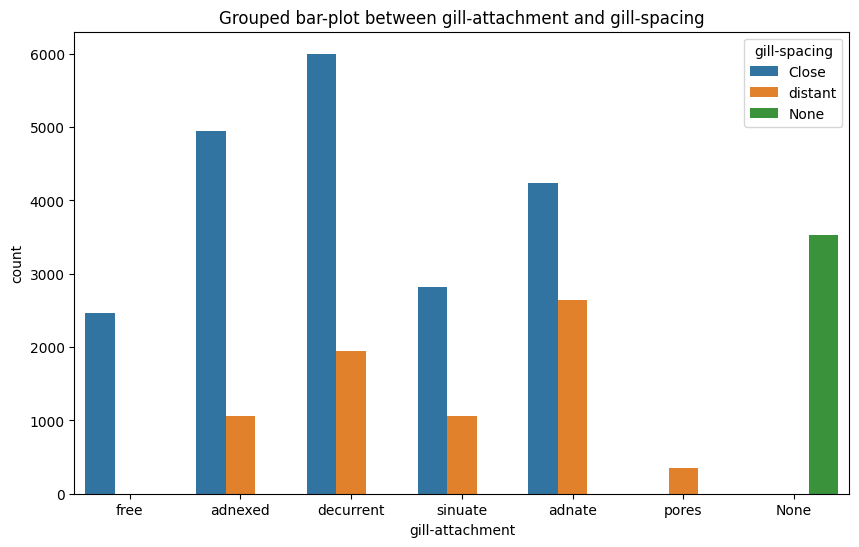

In [16]:
label_mapping = {'c': 'Close', 'd':'distant', 'f':'None'}
x_label_mapping = {'a':'adnate', 'x':'adnexed', 'd':'decurrent', 'e':'free', 's':'sinuate', 'p':'pores', 'f':'None'}

plt.figure(figsize=(10,6))
count = mushroom_df.groupBy('gill-attachment', 'gill-spacing').count().toPandas()
ax = sns.barplot(x='gill-attachment', y="count", data=count, hue='gill-spacing')

legend = ax.get_legend()
for text in legend.texts:
    if text.get_text() in label_mapping:
        text.set_text(label_mapping[text.get_text()])

current_x_labels = [item.get_text() for item in ax.get_xticklabels()]
new_x_labels = [x_label_mapping[label] for label in current_x_labels]
ax.set_xticklabels(new_x_labels, rotation=0) 
plt.title('Grouped bar-plot between gill-attachment and gill-spacing')
plt.show()

### Grouping by season

/var/folders/n8/0xyp_8ms7sx0vdtw_lzp5dv00000gn/T/ipykernel_83161/2002085970.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels, rotation=0)


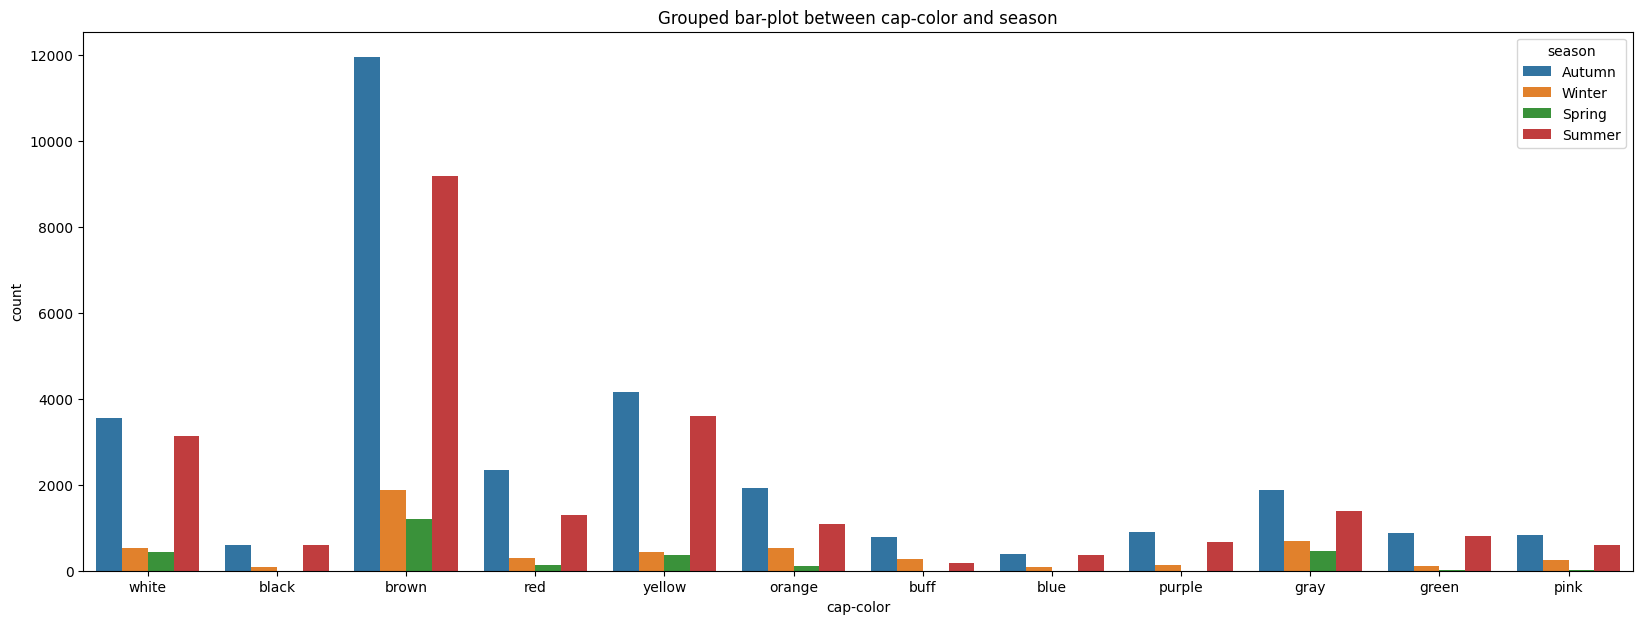

In [17]:
label_mapping = {'a': 'Autumn', 'w': 'Winter', 's':'Spring', 'u':'Summer'}
x_label_mapping = {'n':'brown', 'b':'buff', 'g':'gray', 'r':'green', 'p':'pink', 'u':'purple', 'e':'red', 'w':'white', 'y':'yellow', 'l':'blue', 'o':'orange', 'k':'black'}

plt.figure(figsize=(20,7))
count = mushroom_df.groupBy('cap-color', 'season').count().toPandas()
ax = sns.barplot(x='cap-color', y="count", data=count, hue='season')

legend = ax.get_legend()
for text in legend.texts:
    if text.get_text() in label_mapping:
        text.set_text(label_mapping[text.get_text()])

current_x_labels = [item.get_text() for item in ax.get_xticklabels()]
new_x_labels = [x_label_mapping[label] for label in current_x_labels]
ax.set_xticklabels(new_x_labels, rotation=0) 

plt.title('Grouped bar-plot between cap-color and season')
plt.show()

/var/folders/n8/0xyp_8ms7sx0vdtw_lzp5dv00000gn/T/ipykernel_83161/168426056.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels, rotation=0)


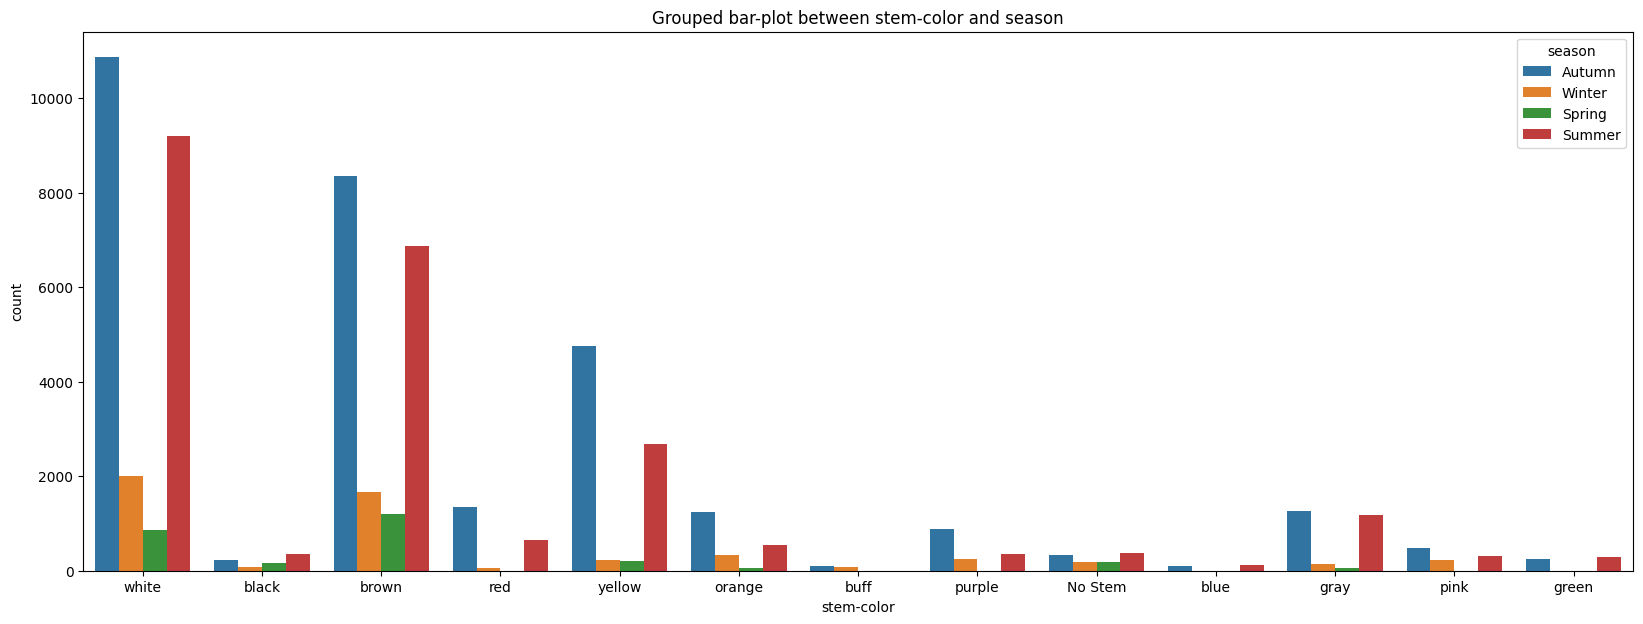

In [18]:
x_label_mapping = {'n':'brown', 'b':'buff', 'g':'gray', 'r':'green', 'p':'pink', 'u':'purple', 'e':'red', 'w':'white', 'y':'yellow', 'l':'blue', 'o':'orange', 'k':'black', 'f':'No Stem'}

plt.figure(figsize=(20,7))
count = mushroom_df.groupBy('stem-color', 'season').count().toPandas()
ax = sns.barplot(x='stem-color', y="count", data=count, hue='season')

legend = ax.get_legend()
for text in legend.texts:
    if text.get_text() in label_mapping:
        text.set_text(label_mapping[text.get_text()])

current_x_labels = [item.get_text() for item in ax.get_xticklabels()]
new_x_labels = [x_label_mapping[label] for label in current_x_labels]
ax.set_xticklabels(new_x_labels, rotation=0) 

plt.title('Grouped bar-plot between stem-color and season')
plt.show()

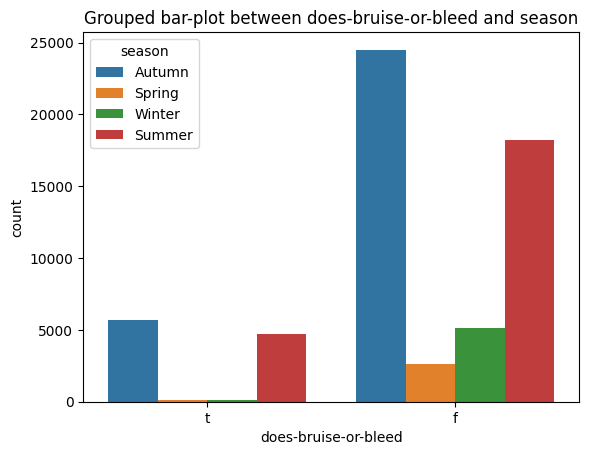

In [19]:

count = mushroom_df.groupBy('does-bruise-or-bleed', 'season').count().toPandas()
ax = sns.barplot(x='does-bruise-or-bleed', y="count", data=count, hue='season')

legend = ax.get_legend()
for text in legend.texts:
    if text.get_text() in label_mapping:
        text.set_text(label_mapping[text.get_text()])

plt.title('Grouped bar-plot between does-bruise-or-bleed and season')
plt.show()

Text(0.5, 1.0, 'Grouped bar-plot between has-ring and season')

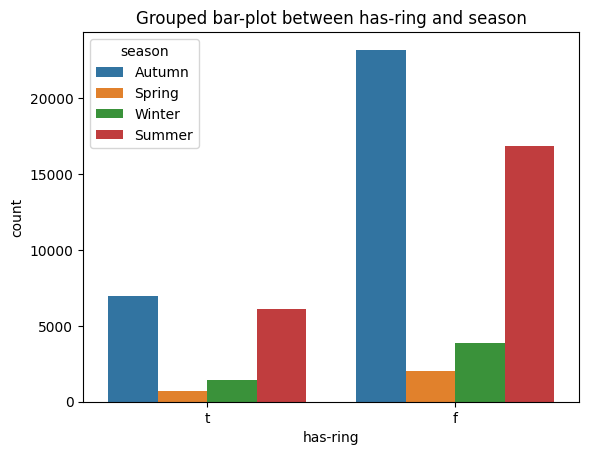

In [20]:
count = mushroom_df.groupBy('has-ring', 'season').count().toPandas()
ax = sns.barplot(x='has-ring', y="count", data=count, hue='season')
legend = ax.get_legend()
for text in legend.texts:
    if text.get_text() in label_mapping:
        text.set_text(label_mapping[text.get_text()])
plt.title('Grouped bar-plot between has-ring and season')

/var/folders/n8/0xyp_8ms7sx0vdtw_lzp5dv00000gn/T/ipykernel_83161/1054613873.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels, rotation=0)


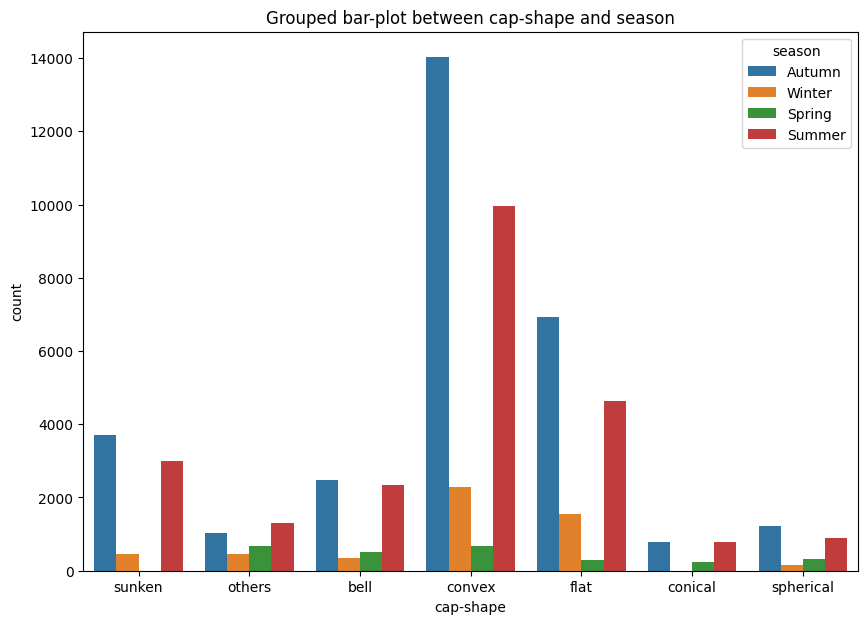

In [21]:
plt.figure(figsize=(10,7))
x_label_mapping = {'b':'bell', 'c':'conical', 'x':'convex', 'f':'flat', 's':'sunken', 'p':'spherical', 'o':'others'}
count = mushroom_df.groupBy('cap-shape', 'season').count().toPandas()
ax = sns.barplot(x='cap-shape', y="count", data=count, hue='season')


legend = ax.get_legend()
for text in legend.texts:
    if text.get_text() in label_mapping:
        text.set_text(label_mapping[text.get_text()])
        
current_x_labels = [item.get_text() for item in ax.get_xticklabels()]
new_x_labels = [x_label_mapping[label] for label in current_x_labels]
ax.set_xticklabels(new_x_labels, rotation=0) 

plt.title('Grouped bar-plot between cap-shape and season')
plt.show()

/var/folders/n8/0xyp_8ms7sx0vdtw_lzp5dv00000gn/T/ipykernel_83161/1981665677.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels, rotation=0)


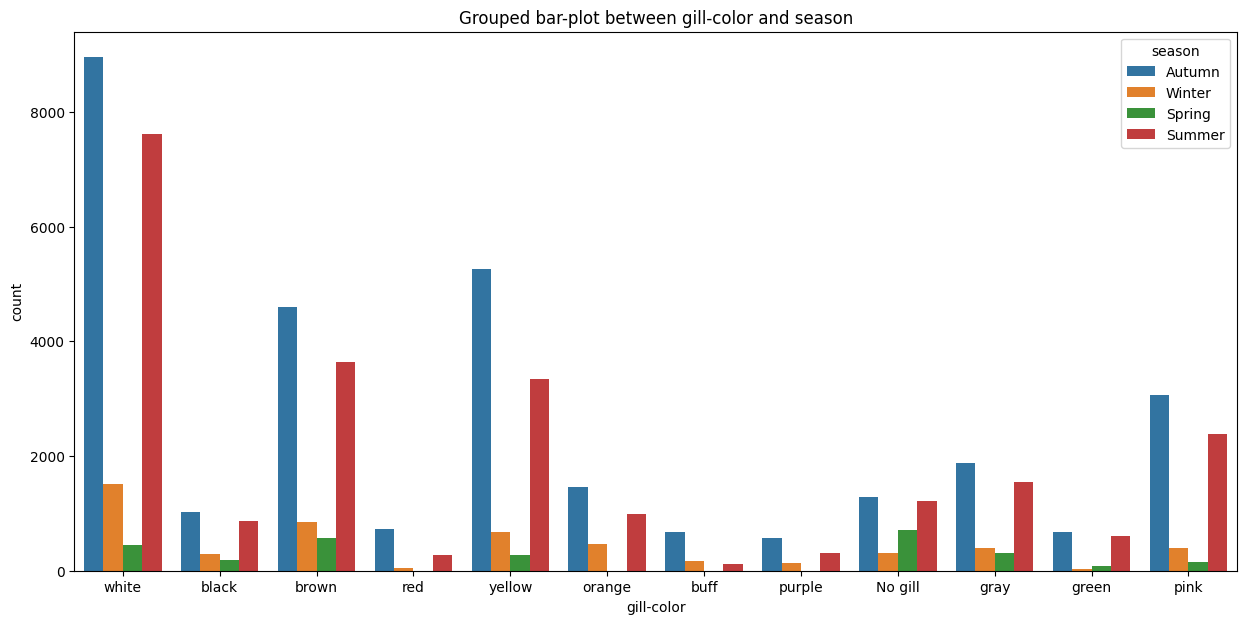

In [22]:
plt.figure(figsize=(15,7))
x_label_mapping = {'n':'brown', 'b':'buff', 'g':'gray', 'r':'green', 'p':'pink', 'u':'purple', 'e':'red', 'w':'white', 'y':'yellow', 'l':'blue', 'o':'orange', 'k':'black', 'f':'No gill'}

count = mushroom_df.groupBy('gill-color', 'season').count().toPandas()

ax = sns.barplot(x='gill-color', y="count", data=count, hue='season')

legend = ax.get_legend()
for text in legend.texts:
    if text.get_text() in label_mapping:
        text.set_text(label_mapping[text.get_text()])

current_x_labels = [item.get_text() for item in ax.get_xticklabels()]
new_x_labels = [x_label_mapping[label] for label in current_x_labels]
ax.set_xticklabels(new_x_labels, rotation=0) 

plt.title('Grouped bar-plot between gill-color and season')
plt.show()

/var/folders/n8/0xyp_8ms7sx0vdtw_lzp5dv00000gn/T/ipykernel_83161/3092491683.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels, rotation=0)


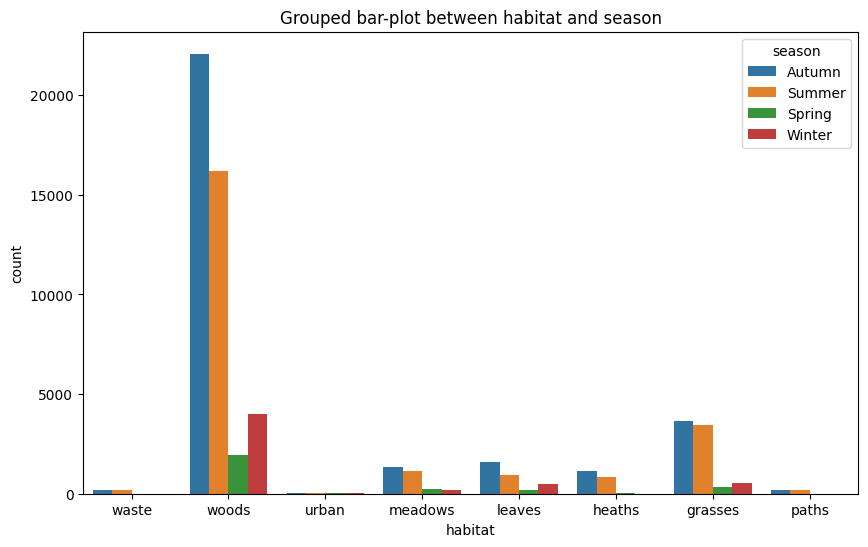

In [23]:
x_label_mapping = {'g':'grasses', 'l':'leaves', 'm':'meadows', 'p':'paths', 'h':'heaths', 'u':'urban', 'w':'waste', 'd':'woods'}

plt.figure(figsize=(10,6))
count = mushroom_df.groupBy('habitat', 'season').count().toPandas()
ax = sns.barplot(x='habitat', y="count", data=count, hue='season')

legend = ax.get_legend()
for text in legend.texts:
    if text.get_text() in label_mapping:
        text.set_text(label_mapping[text.get_text()])

current_x_labels = [item.get_text() for item in ax.get_xticklabels()]
new_x_labels = [x_label_mapping[label] for label in current_x_labels]
ax.set_xticklabels(new_x_labels, rotation=0) 

plt.title('Grouped bar-plot between habitat and season')
plt.show()

### Grouping by class

/var/folders/n8/0xyp_8ms7sx0vdtw_lzp5dv00000gn/T/ipykernel_83161/2054672731.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels, rotation=0)


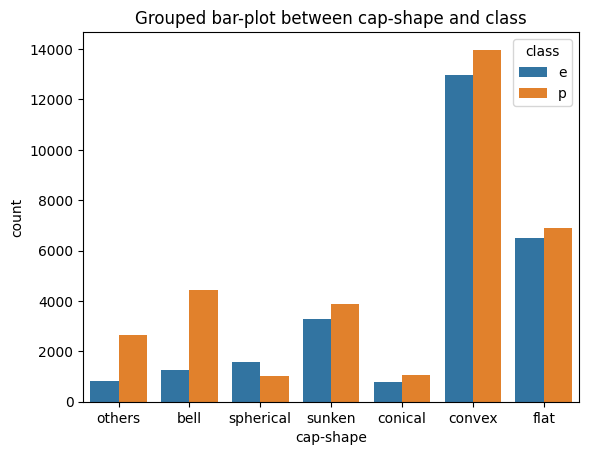

In [24]:
x_label_mapping = {'b':'bell', 'c':'conical', 'x':'convex', 'f':'flat', 's':'sunken', 'p':'spherical', 'o':'others'}
count = mushroom_df.groupBy('cap-shape', 'class').count().toPandas()
ax = sns.barplot(x='cap-shape', y="count", data=count, hue='class')

current_x_labels = [item.get_text() for item in ax.get_xticklabels()]
new_x_labels = [x_label_mapping[label] for label in current_x_labels]
ax.set_xticklabels(new_x_labels, rotation=0) 

plt.title('Grouped bar-plot between cap-shape and class')
plt.show()

/var/folders/n8/0xyp_8ms7sx0vdtw_lzp5dv00000gn/T/ipykernel_83161/3411784187.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels, rotation=0)


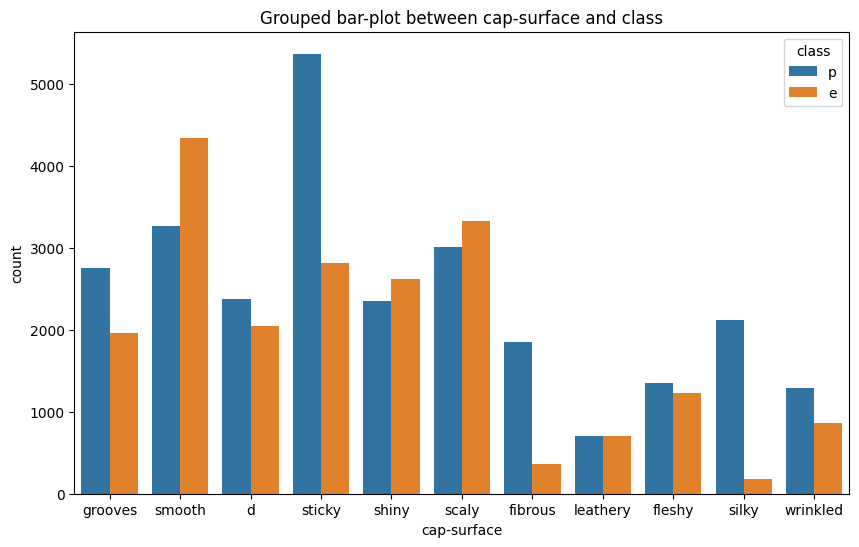

In [25]:
# we don't know which value corresponds to d since this infomation is missed in the metadata
x_label_mapping = {'i':'fibrous', 'g':'grooves', 'y':'scaly', 's':'smooth', 'h':'shiny', 'l':'leathery', 'k':'silky', 't':'sticky', 'w':'wrinkled', 'e':'fleshy','d':'d'}

plt.figure(figsize=(10,6))
count = mushroom_df.groupBy('cap-surface', 'class').count().toPandas()
ax = sns.barplot(x='cap-surface', y="count", data=count, hue='class')

current_x_labels = [item.get_text() for item in ax.get_xticklabels()]
new_x_labels = [x_label_mapping[label] for label in current_x_labels]
ax.set_xticklabels(new_x_labels, rotation=0) 

plt.title('Grouped bar-plot between cap-surface and class')
plt.show()

/var/folders/n8/0xyp_8ms7sx0vdtw_lzp5dv00000gn/T/ipykernel_83161/3210260656.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels, rotation=0)


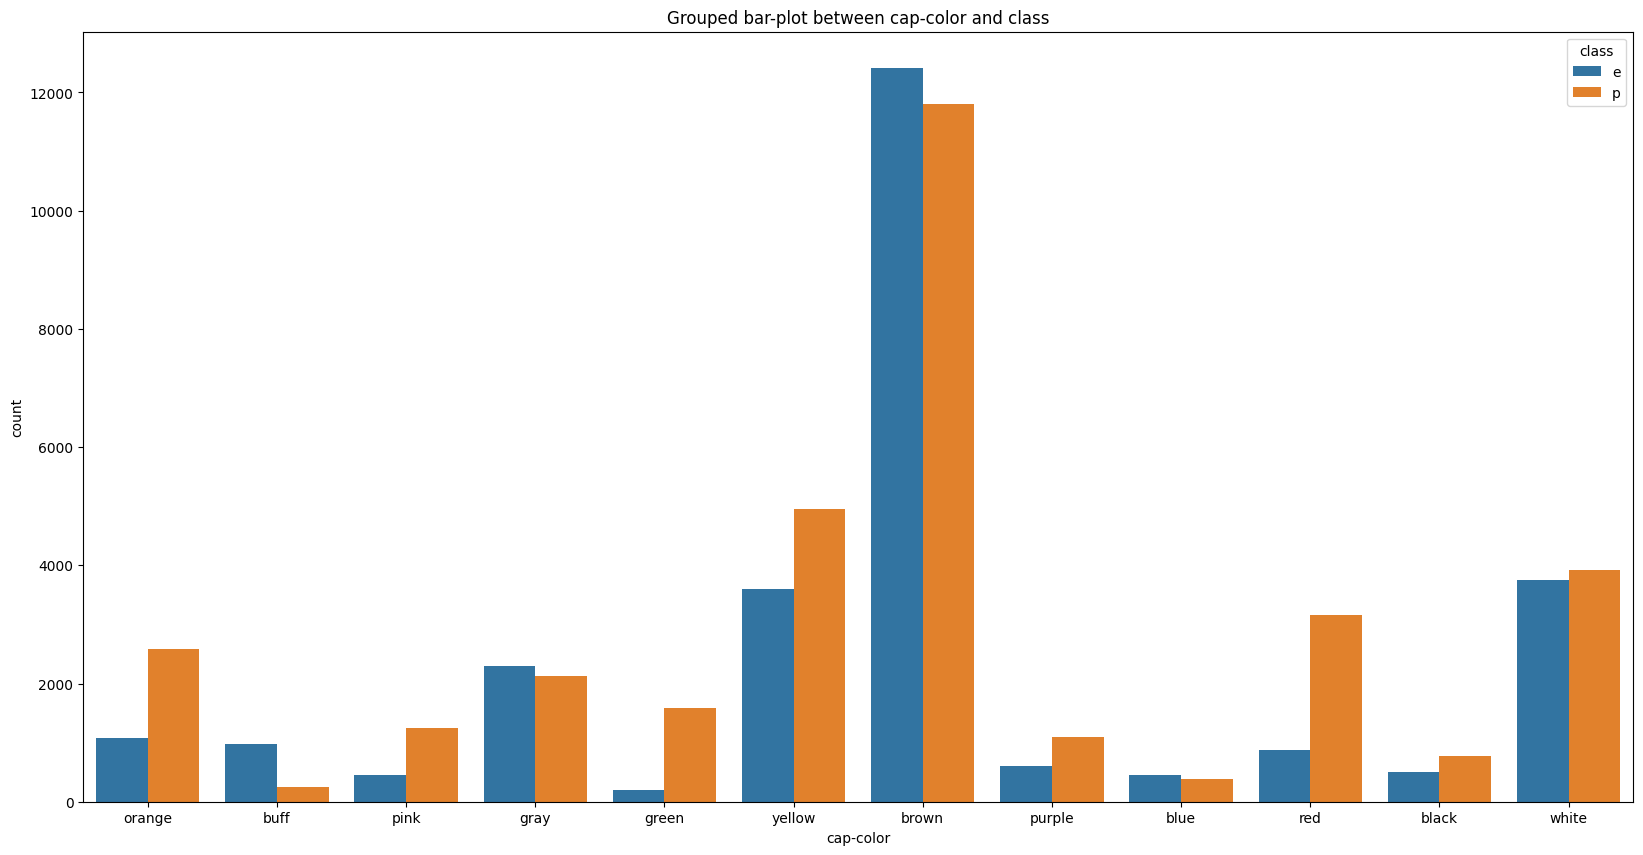

In [26]:
x_label_mapping = {'n':'brown', 'b':'buff', 'g':'gray', 'r':'green', 'p':'pink', 'u':'purple', 'e':'red', 'w':'white', 'y':'yellow', 'l':'blue', 'o':'orange', 'k':'black'}

plt.figure(figsize=(20,10))
count = mushroom_df.groupBy('cap-color', 'class').count().toPandas()
ax = sns.barplot(x='cap-color', y="count", data=count, hue='class')

current_x_labels = [item.get_text() for item in ax.get_xticklabels()]
new_x_labels = [x_label_mapping[label] for label in current_x_labels]
ax.set_xticklabels(new_x_labels, rotation=0) 

plt.title('Grouped bar-plot between cap-color and class')
plt.show()

/var/folders/n8/0xyp_8ms7sx0vdtw_lzp5dv00000gn/T/ipykernel_83161/2008433345.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels, rotation=0)


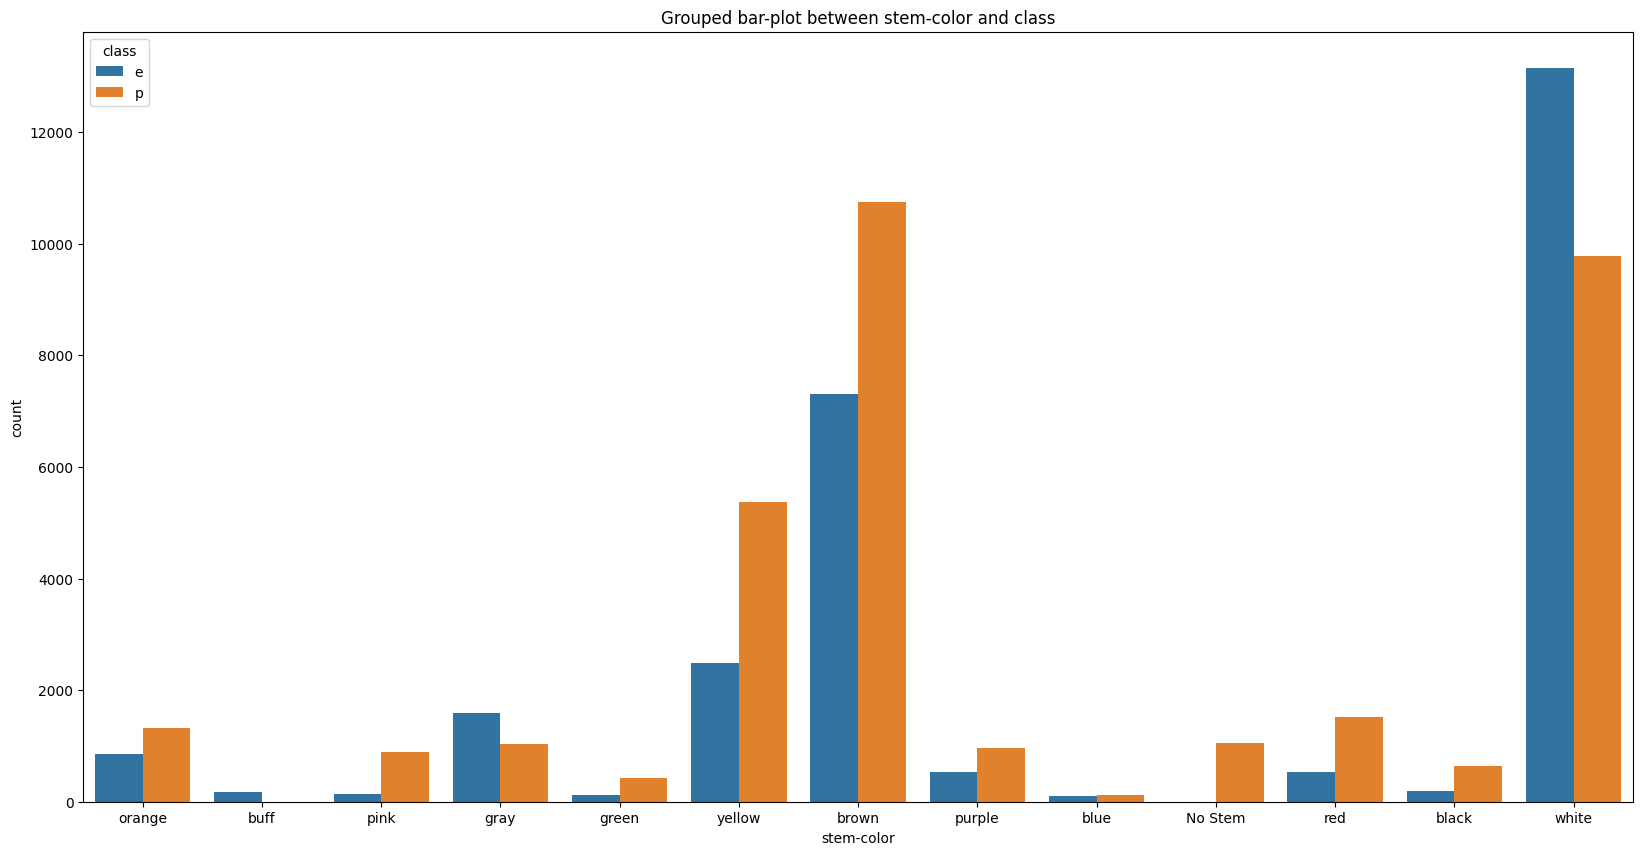

In [27]:
x_label_mapping = {'n':'brown', 'b':'buff', 'g':'gray', 'r':'green', 'p':'pink', 'u':'purple', 'e':'red', 'w':'white', 'y':'yellow', 'l':'blue', 'o':'orange', 'k':'black', 'f':'No Stem'}

plt.figure(figsize=(20,10))
count = mushroom_df.groupBy('stem-color', 'class').count().toPandas()
ax = sns.barplot(x='stem-color', y="count", data=count, hue='class')

legend = ax.get_legend()
for text in legend.texts:
    if text.get_text() in label_mapping:
        text.set_text(label_mapping[text.get_text()])

current_x_labels = [item.get_text() for item in ax.get_xticklabels()]
new_x_labels = [x_label_mapping[label] for label in current_x_labels]
ax.set_xticklabels(new_x_labels, rotation=0) 

plt.title('Grouped bar-plot between stem-color and class')
plt.show()

/var/folders/n8/0xyp_8ms7sx0vdtw_lzp5dv00000gn/T/ipykernel_83161/1382857781.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels, rotation=0)


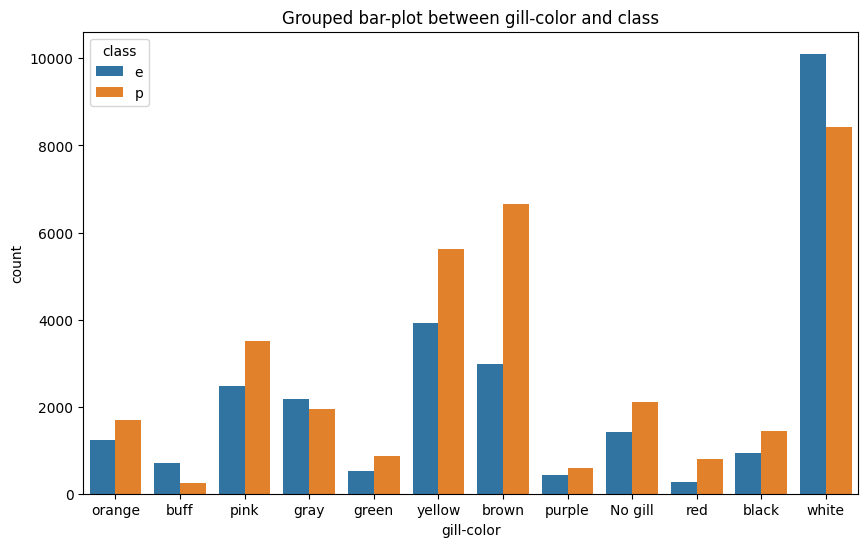

In [28]:
plt.figure(figsize=(10,6))
x_label_mapping = {'n':'brown', 'b':'buff', 'g':'gray', 'r':'green', 'p':'pink', 'u':'purple', 'e':'red', 'w':'white', 'y':'yellow', 'l':'blue', 'o':'orange', 'k':'black', 'f':'No gill'}
count = mushroom_df.groupBy('gill-color', 'class').count().toPandas()
ax = sns.barplot(x='gill-color', y="count", data=count, hue='class')

current_x_labels = [item.get_text() for item in ax.get_xticklabels()]
new_x_labels = [x_label_mapping[label] for label in current_x_labels]
ax.set_xticklabels(new_x_labels, rotation=0) 

plt.title('Grouped bar-plot between gill-color and class')
plt.show()

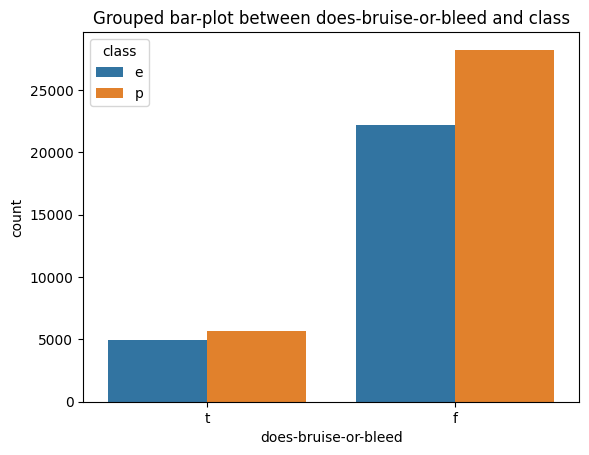

In [29]:
count = mushroom_df.groupBy('does-bruise-or-bleed', 'class').count().toPandas()
sns.barplot(x='does-bruise-or-bleed', y="count", data=count, hue='class')

plt.title('Grouped bar-plot between does-bruise-or-bleed and class')
plt.show()

/var/folders/n8/0xyp_8ms7sx0vdtw_lzp5dv00000gn/T/ipykernel_83161/549832332.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels, rotation=0)


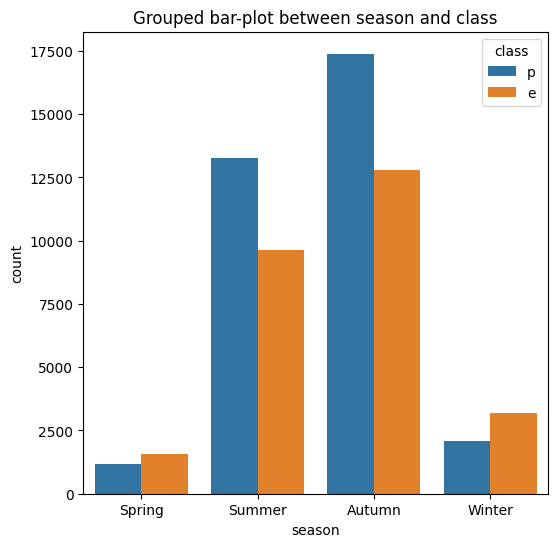

In [30]:
x_label_mapping = {'a': 'Autumn', 'w': 'Winter', 's':'Spring', 'u':'Summer'}

plt.figure(figsize=(6,6))
count = mushroom_df.groupBy('season', 'class').count().toPandas()
ax = sns.barplot(x='season', y="count", data=count, hue='class')

current_x_labels = [item.get_text() for item in ax.get_xticklabels()]
new_x_labels = [x_label_mapping[label] for label in current_x_labels]
ax.set_xticklabels(new_x_labels, rotation=0) 

plt.title('Grouped bar-plot between season and class')
plt.show()

/var/folders/n8/0xyp_8ms7sx0vdtw_lzp5dv00000gn/T/ipykernel_83161/3713471996.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels, rotation=0)


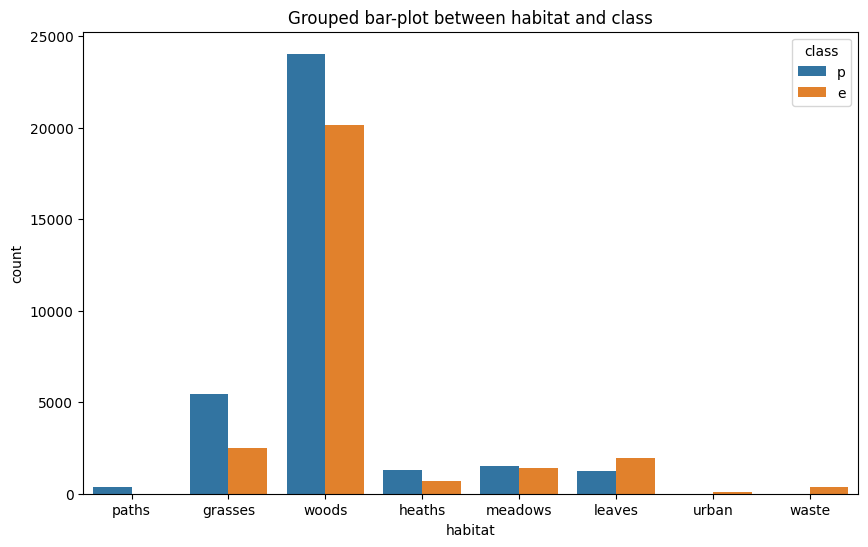

In [31]:
x_label_mapping = {'g':'grasses', 'l':'leaves', 'm':'meadows', 'p':'paths', 'h':'heaths', 'u':'urban', 'w':'waste', 'd':'woods'}

plt.figure(figsize=(10,6))
count = mushroom_df.groupBy('habitat', 'class').count().toPandas()
ax = sns.barplot(x='habitat', y="count", data=count, hue='class')

current_x_labels = [item.get_text() for item in ax.get_xticklabels()]
new_x_labels = [x_label_mapping[label] for label in current_x_labels]
ax.set_xticklabels(new_x_labels, rotation=0) 

plt.title('Grouped bar-plot between habitat and class')
plt.show()

/var/folders/n8/0xyp_8ms7sx0vdtw_lzp5dv00000gn/T/ipykernel_83161/1884397465.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels, rotation=0)


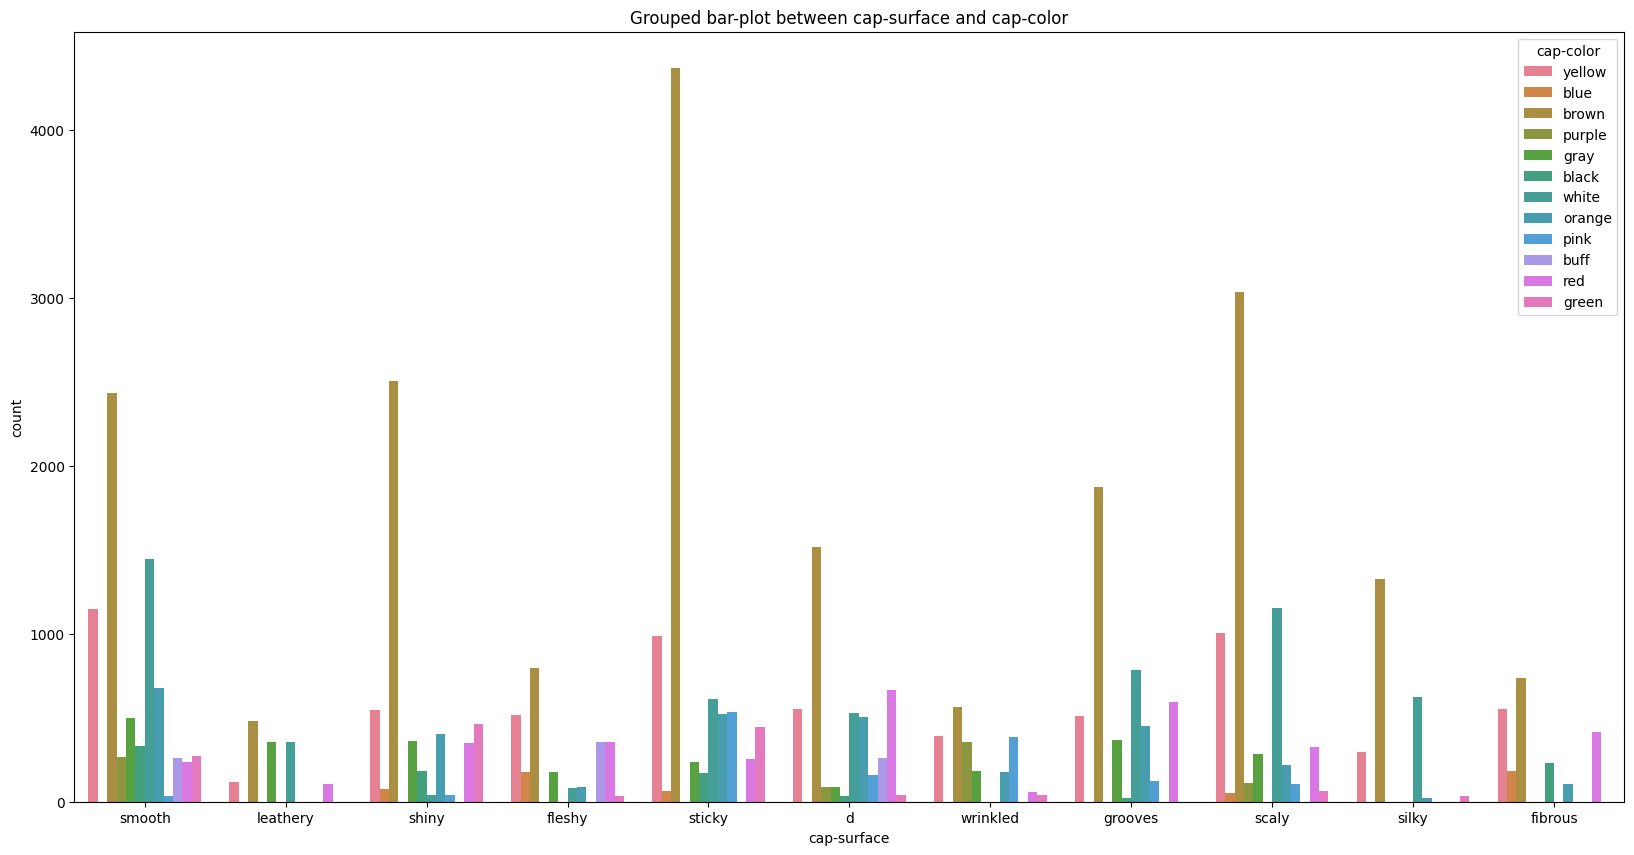

In [32]:
cap_label_mapping = {'n':'brown', 'b':'buff', 'g':'gray', 'r':'green', 'p':'pink', 'u':'purple', 'e':'red', 'w':'white', 'y':'yellow', 'l':'blue', 'o':'orange', 'k':'black'}
# we don't know which value corresponds to d since this infomation is missed in the metadata
x_label_mapping = {'i':'fibrous', 'g':'grooves', 'y':'scaly', 's':'smooth', 'h':'shiny', 'l':'leathery', 'k':'silky', 't':'sticky', 'w':'wrinkled', 'e':'fleshy','d':'d'}

plt.figure(figsize=(20,10))
count = mushroom_df.groupBy('cap-surface', 'cap-color').count().toPandas()
ax = sns.barplot(x='cap-surface', y="count", data=count, hue='cap-color')

legend = ax.get_legend()
for text in legend.texts:
    if text.get_text() in cap_label_mapping:
        text.set_text(cap_label_mapping[text.get_text()])

current_x_labels = [item.get_text() for item in ax.get_xticklabels()]
new_x_labels = [x_label_mapping[label] for label in current_x_labels]
ax.set_xticklabels(new_x_labels, rotation=0) 

plt.title('Grouped bar-plot between cap-surface and cap-color')
plt.show()

<Axes: xlabel='has-ring', ylabel='count'>

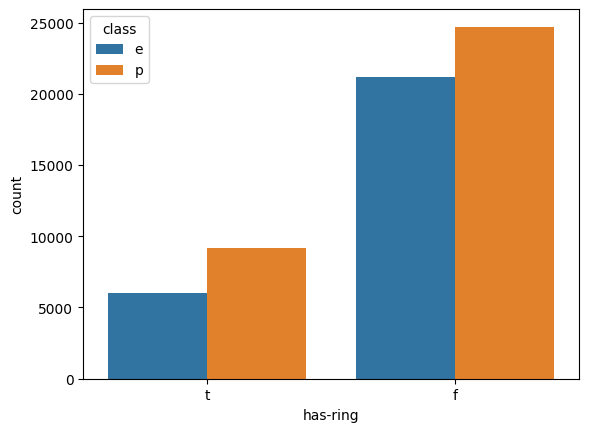

In [33]:
count = mushroom_df.groupBy('has-ring', 'class').count().toPandas()
sns.barplot(x='has-ring', y="count", data=count, hue='class')

## Outliers detection

In [34]:
# convert values to the same scale
mushroom_df = mushroom_df.withColumn("stem-width", round(col("stem-width") / 10, 3))

In [35]:
mushroom_df.show()

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|    p|       15.26|        x|          g|        o|                   f|              e|        NULL|         w|      16.95|     1.709|        s|           y|         w|        u|         w|       t|        g|             NULL|      d|     w|
|    p|        16.6|    

In [36]:
mushroom_df_sample = mushroom_df.sample(withReplacement = False, fraction = 0.05, seed=42)
mushroom_df_sample_df = mushroom_df_sample.toPandas()

### Scatterplots

Text(0.5, 1.0, 'Scatter plot for cap-diameter/stem-height')

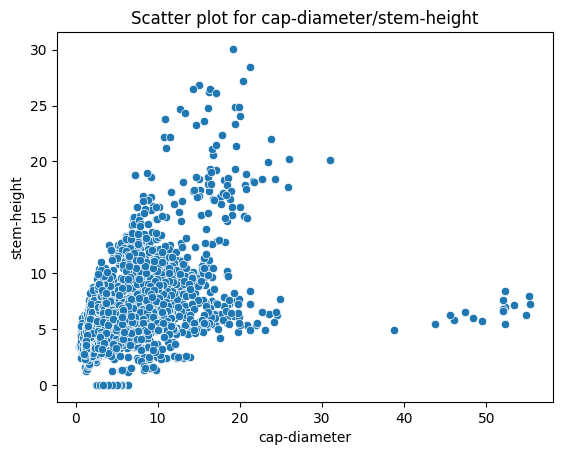

In [37]:
sns.scatterplot(data=mushroom_df_sample_df, x='cap-diameter', y='stem-height')
plt.title('Scatter plot for cap-diameter/stem-height')

Text(0.5, 1.0, 'Scatter plot for cap-diameter/stem-width')

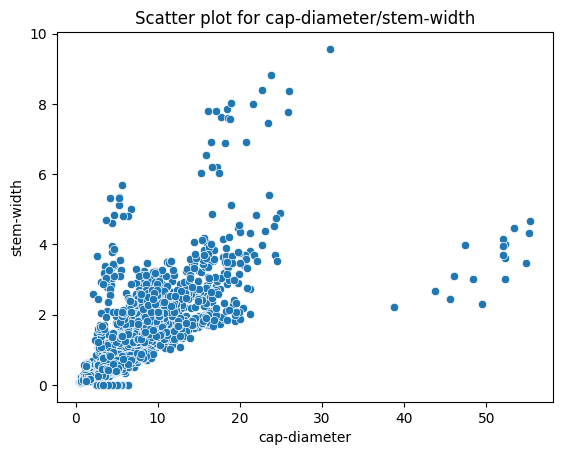

In [38]:
sns.scatterplot(data=mushroom_df_sample_df, x='cap-diameter', y='stem-width')
plt.title('Scatter plot for cap-diameter/stem-width')

Text(0.5, 1.0, 'Scatter plot for stem-width/stem-height')

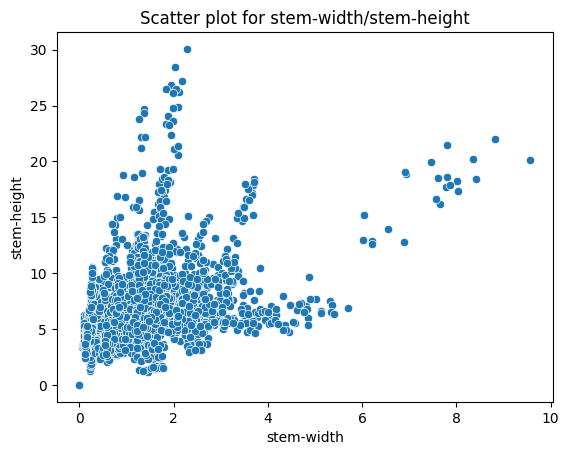

In [39]:
sns.scatterplot(data=mushroom_df_sample_df, x='stem-width', y='stem-height')
plt.title('Scatter plot for stem-width/stem-height')

Scatter plot colored by categorical attributes

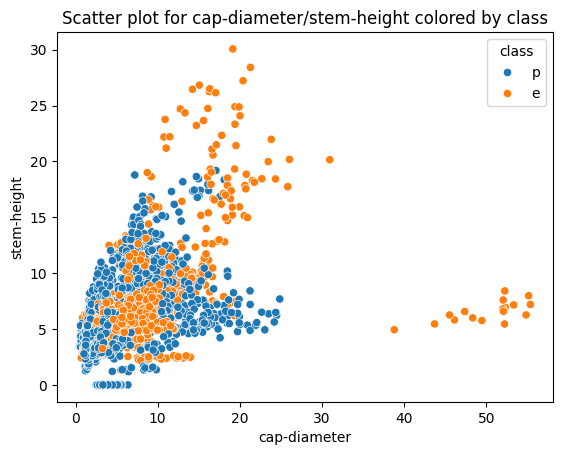

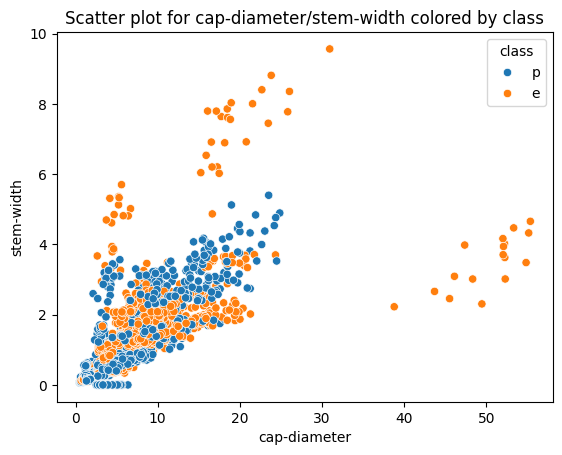

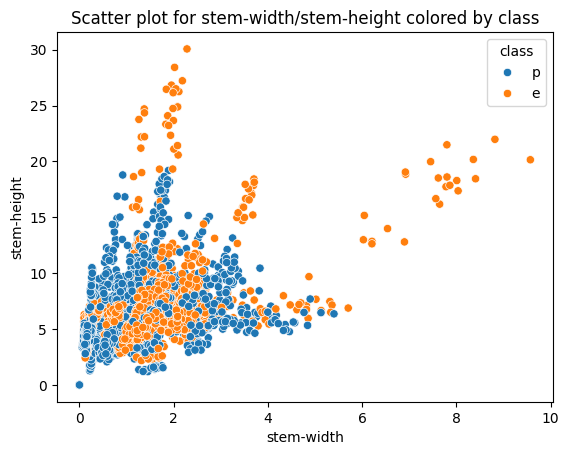

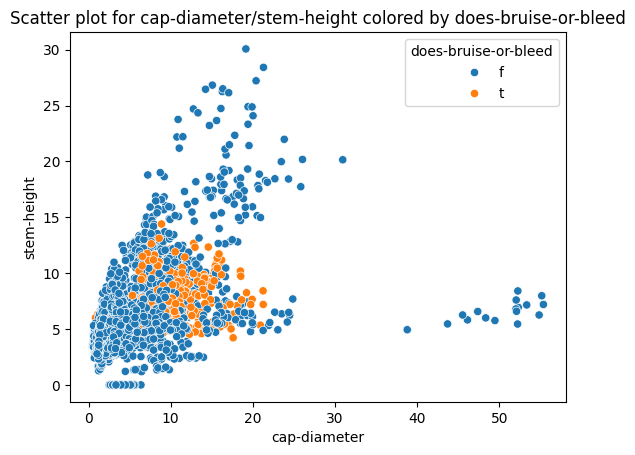

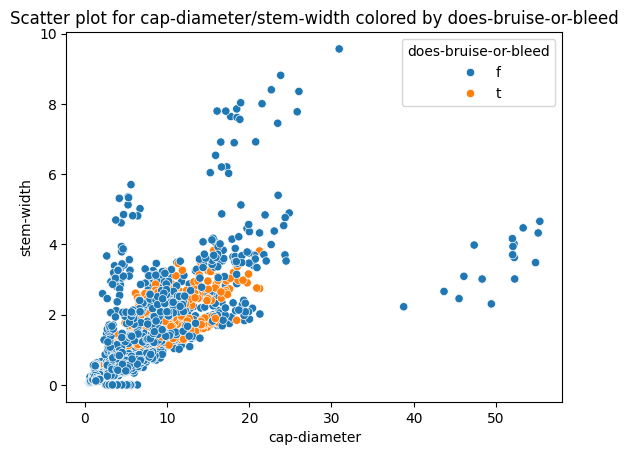

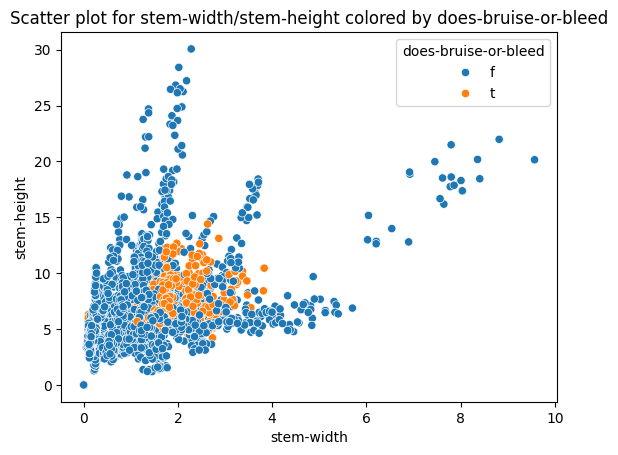

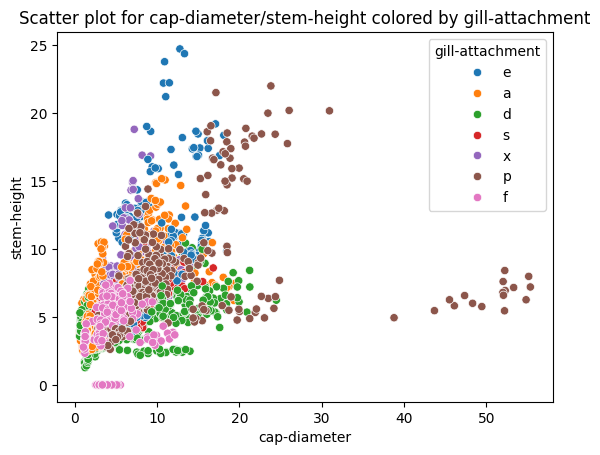

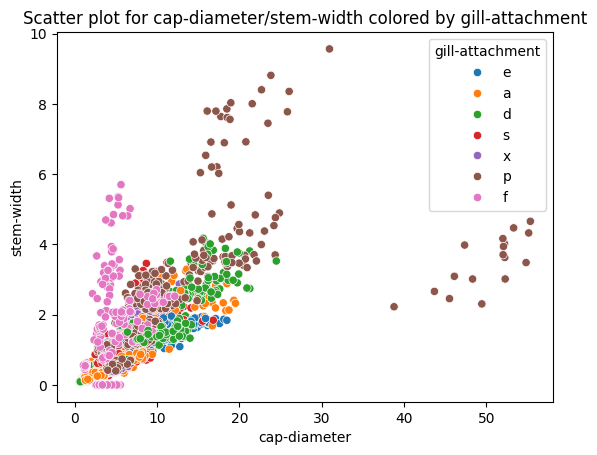

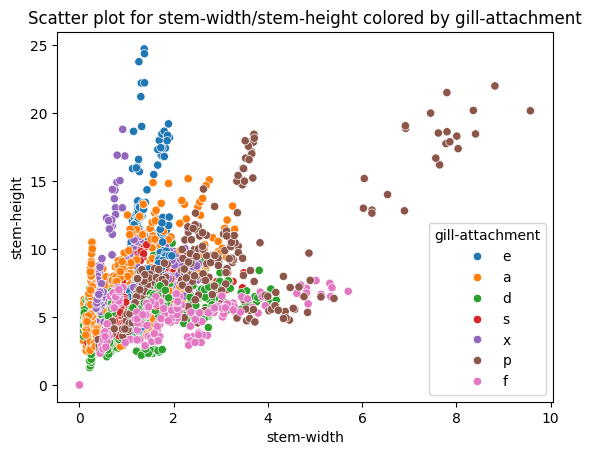

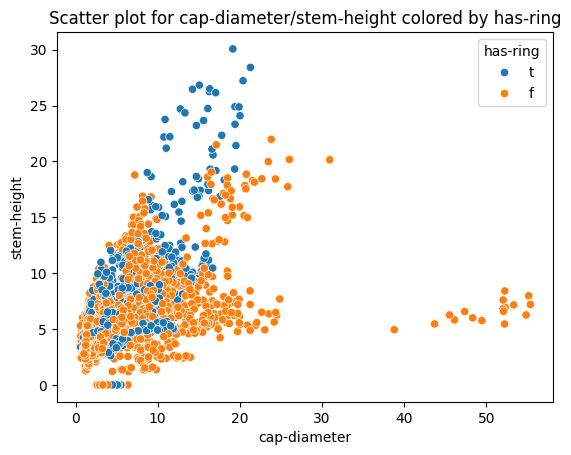

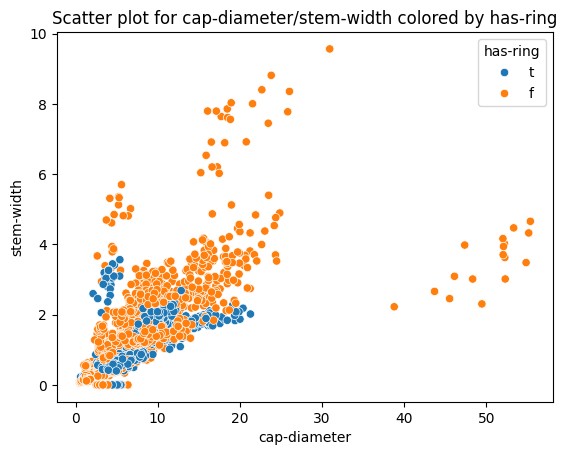

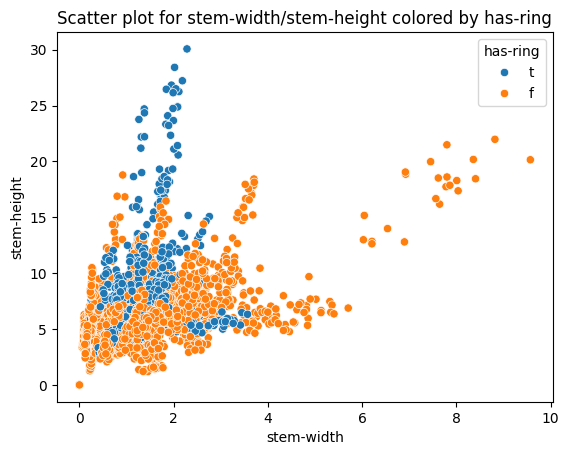

In [40]:
for elem in ['class', 'does-bruise-or-bleed', 'gill-attachment', 'has-ring']:
    sns.scatterplot(data=mushroom_df_sample_df, x='cap-diameter', y='stem-height', hue=elem)
    plt.title(f'Scatter plot for cap-diameter/stem-height colored by {elem}')
    plt.show()
    sns.scatterplot(data=mushroom_df_sample_df, x='cap-diameter', y='stem-width', hue=elem)
    plt.title(f'Scatter plot for cap-diameter/stem-width colored by {elem}')
    plt.show()
    sns.scatterplot(data=mushroom_df_sample_df, x='stem-width', y='stem-height', hue=elem)
    plt.title(f'Scatter plot for stem-width/stem-height colored by {elem}')
    plt.show()

### Boxplots

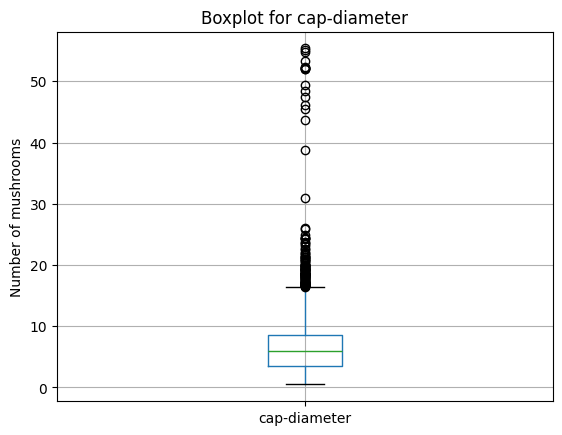

Whiskers:  [3.45, 0.48, 8.64, 16.39]
Median:  5.89


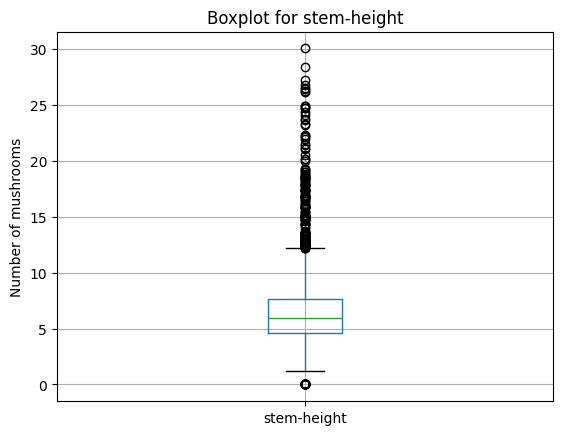

Whiskers:  [4.64, 1.19, 7.672499999999999, 12.2]
Median:  5.925


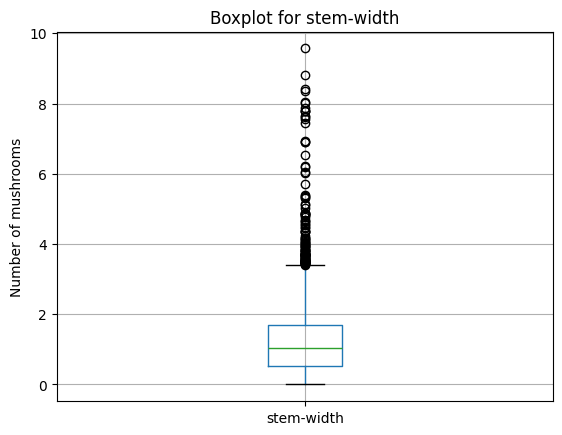

Whiskers:  [0.536, 0.0, 1.68425, 3.401]
Median:  1.033


In [64]:
for c in num_cols:
    plot = mushroom_df_sample.toPandas().boxplot(column=c, return_type = 'dict')
    plt.title(f'Boxplot for {c}')
    plt.ylabel('Number of mushrooms')
    plt.show()
    
    whisker_values = []
    for whisker in plot['whiskers']:
        whisker_values.extend(whisker.get_ydata())
    print('Whiskers: ', whisker_values)
    print('Median: ', plot['medians'][0].get_ydata()[0])
    



# Data Preparation

In [42]:
mushroom_df_no_dupl = mushroom_df.dropDuplicates()
mushroom_df_no_dupl.count()

60923

In [43]:
mushroom_df_no_dupl.createOrReplaceTempView("Mushrooms_Data_No_Duplicates")

## Outlier (error) cleaning

In [44]:
# from primary dataset
cap_diameter_real_min = 0.4
cap_diameter_real_max = 30

stem_height_real_min =  0
stem_height_real_max = 35

stem_width_real_min =  0
stem_width_real_max =  10

In [45]:
outlier_error_df = spark.sql(f"SELECT * FROM Mushrooms_Data_No_Duplicates WHERE NOT (`cap-diameter`>= {cap_diameter_real_min} AND `cap-diameter`<= {cap_diameter_real_max} AND `stem-height`>= {stem_height_real_min} AND `stem-height`<= {stem_height_real_max} AND `stem-width`>= {stem_width_real_min} AND `stem-width`<= {stem_width_real_max})")
outlier_error_df.count()

360

In [46]:
cleaned_df = spark.sql(f"SELECT * FROM Mushrooms_Data_No_Duplicates WHERE `cap-diameter`>= {cap_diameter_real_min} AND `cap-diameter`<= {cap_diameter_real_max} AND `stem-height`>= {stem_height_real_min} AND `stem-height`<= {stem_height_real_max} AND `stem-width`>= {stem_width_real_min} AND `stem-width`<= {stem_width_real_max}")
cleaned_df.count()

60563

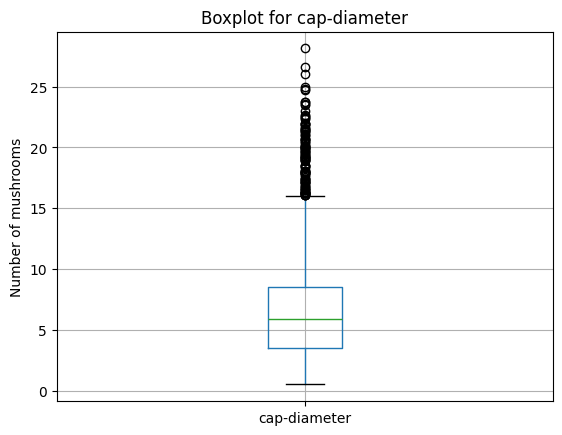

Whiskers:  [3.5425, 0.51, 8.54, 16.03]
Median:  5.885


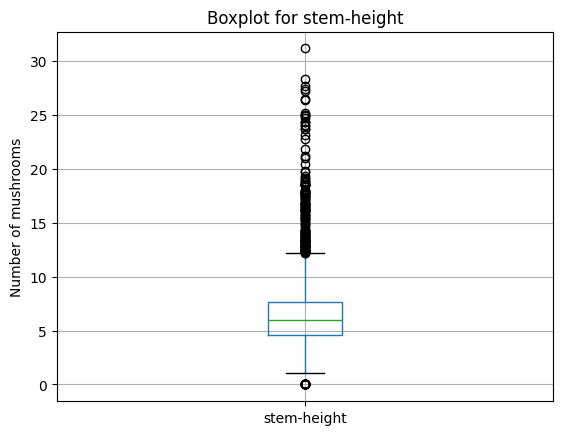

Whiskers:  [4.63, 1.1, 7.6475, 12.17]
Median:  5.94


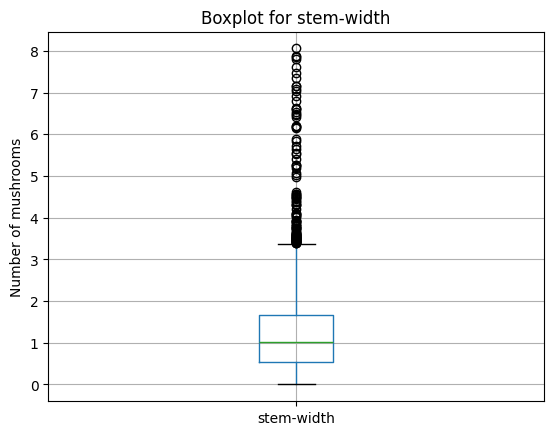

Whiskers:  [0.5375000000000001, 0.0, 1.67075, 3.365]
Median:  1.016


In [47]:
cleaned_mushroom_df_sample = cleaned_df.sample(withReplacement = False, fraction = 0.05, seed=10)
for c in num_cols:
    plot = cleaned_mushroom_df_sample.toPandas().boxplot(column=c, return_type = 'dict')
    plt.title(f'Boxplot for {c}')
    plt.ylabel('Number of mushrooms')
    plt.show()
    
    whisker_values = []
    for whisker in plot['whiskers']:
        whisker_values.extend(whisker.get_ydata())
    print('Whiskers: ', whisker_values)
    print('Median: ', plot['medians'][0].get_ydata()[0])

## Null Values Filling and cleaning 

Attributes with too many missing values that we drop:

stem-root: 51538/61069 null values

stem-surface: 38124/61069 null values

veil-type:  57892/61069 (+ only a class "u")

veil-color: 53656/61069 null values

spore-print-color: 54715/61069 null values

gill-spacing: 25063/61069 null values

In [48]:
mushroom_df_new = cleaned_df.drop(*['stem-root', 'stem-surface', 'veil-type', 'veil-color', 'spore-print-color', 'gill-spacing'])

mushroom_df_new.columns

['class',
 'cap-diameter',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-color',
 'stem-height',
 'stem-width',
 'stem-color',
 'has-ring',
 'ring-type',
 'habitat',
 'season']

In [49]:
for c in mushroom_df_new.columns:
    count = mushroom_df_new.filter(col(c).isNull()).count()
    if  count != 0:
        print(f"{c} : {count}")

cap-surface : 14120
gill-attachment : 9854
ring-type : 2471


In [50]:
window = Window.partitionBy(["cap-shape","cap-color"]).orderBy("cap-shape","cap-color")
temp_df = mushroom_df_new.withColumn("mode", F.mode("cap-surface").over(window))

mushroom_df_new = temp_df.withColumn("cap-surface", F.when(F.col("cap-surface").isNull(), 
                                                             F.col("mode"))
                                     .otherwise(F.col("cap-surface"))).drop('mode')


In [51]:
mushroom_df_new.filter(mushroom_df_new['cap-surface'].isNull()).groupBy('cap-surface').count().show()

+-----------+-----+
|cap-surface|count|
+-----------+-----+
|       NULL|  549|
+-----------+-----+



In [52]:
mushroom_df_new = mushroom_df_new.dropna(subset=['cap-surface'])
mushroom_df_new.filter(mushroom_df_new['cap-surface'].isNull()).groupBy('cap-surface').count().show()

+-----------+-----+
|cap-surface|count|
+-----------+-----+
+-----------+-----+



Text(0.5, 1.0, 'Number of mushrooms per cap-surface')

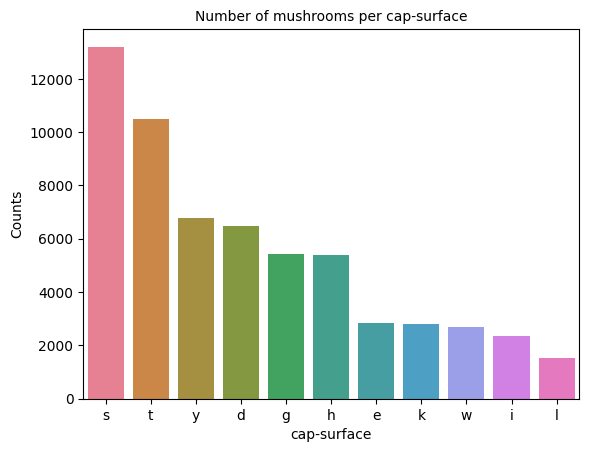

In [53]:
c = 'cap-surface'
col_counts = mushroom_df_new.groupBy(c).count().toPandas()
col_counts = col_counts.sort_values(by='count', ascending=False)
sns.barplot(x=c, y="count", hue=c, data=col_counts)
plt.xlabel(c, size=10)
plt.ylabel("Counts", size=10)
plt.title(f"Number of mushrooms per {c}", size=10)

In [54]:
window = Window.partitionBy(["gill-color"]).orderBy("gill-color")
temp_df = mushroom_df_new.withColumn("mode", F.mode("gill-attachment").over(window))

temp_df_2 = temp_df.withColumn("gill-attachment", 
                         F.when(F.col("gill-attachment").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("gill-attachment")))
mushroom_df_new = temp_df_2.drop("mode")

Text(0.5, 1.0, 'Number of mushrooms per gill-attachment')

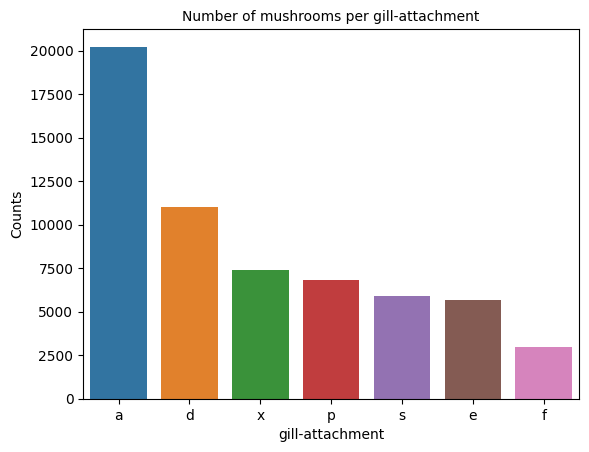

In [55]:
c = 'gill-attachment'
col_counts = mushroom_df_new.groupBy(c).count().toPandas()
col_counts = col_counts.sort_values(by='count', ascending=False)
sns.barplot(x=c, y="count", hue=c, data=col_counts)
plt.xlabel(c, size=10)
plt.ylabel("Counts", size=10)
plt.title(f"Number of mushrooms per {c}", size=10)

In [56]:
mode_value = mushroom_df_new.groupBy("ring-type").count().orderBy('count', ascending=False).first()[0]
print("Mode of column is: ", mode_value)

mushroom_df_new = mushroom_df_new.fillna({"ring-type": mode_value})

Mode of column is:  f


Text(0.5, 1.0, 'Number of mushrooms per ring-type')

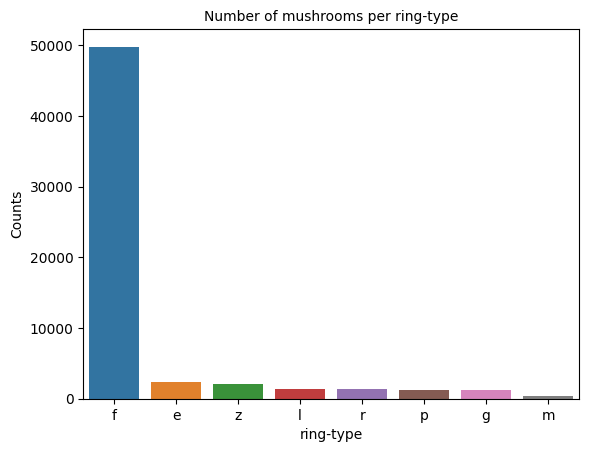

In [57]:
c = 'ring-type'
col_counts = mushroom_df_new.groupBy(c).count().toPandas()
col_counts = col_counts.sort_values(by='count', ascending=False)
sns.barplot(x=c, y="count", hue=c, data=col_counts)
plt.xlabel(c, size=10)
plt.ylabel("Counts", size=10)
plt.title(f"Number of mushrooms per {c}", size=10)

In [58]:
for c in mushroom_df_new.columns:
    count = mushroom_df_new.filter(col(c).isNull()).count()
    print(f"{c} : {count}")

class : 0
cap-diameter : 0
cap-shape : 0
cap-surface : 0
cap-color : 0
does-bruise-or-bleed : 0
gill-attachment : 0
gill-color : 0
stem-height : 0
stem-width : 0
stem-color : 0
has-ring : 0
ring-type : 0
habitat : 0
season : 0


## Correlation matrix

In [59]:
vectorassembler = VectorAssembler(inputCols = num_cols, outputCol= 'numericalfeatures')
output_dataset = vectorassembler.transform(mushroom_df_new)

In [60]:
pearson = Correlation.corr(output_dataset, 'numericalfeatures', 'pearson').collect()[0][0]
correlation_array = pearson.toArray() 

correlation_df = pd.DataFrame(
    correlation_array,
    index = num_cols,
    columns = num_cols
)

correlation_df

24/05/30 20:09:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


,cap-diameter,stem-height,stem-width
cap-diameter,1.000000,0.547179,0.768508
stem-height,0.547179,1.000000,0.445360
stem-width,0.768508,0.445360,1.000000


Text(0.5, 1.0, 'Correlation Matrix')

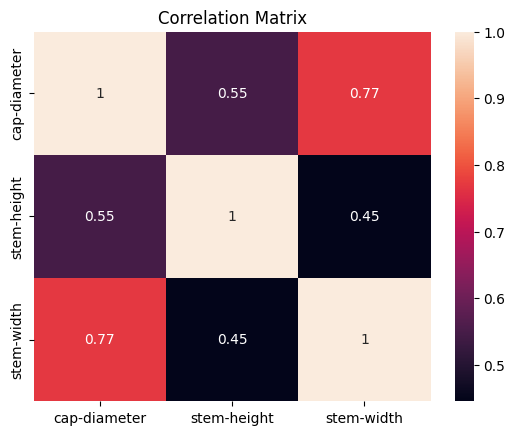

In [61]:
sns.heatmap(correlation_df, annot=True)
plt.title('Correlation Matrix')

In [62]:
# save the new dataset
mushroom_df_new.write.csv('dataset/cleaned.csv', header=True, mode='overwrite')